# Stark Maps

In [1]:
%pip install -q matplotlib numpy pairinteraction

import matplotlib.pyplot as plt
import numpy as np
import pairinteraction.real as pi
from pairinteraction.visualization.colormaps import alphamagma

In [2]:
if pi.Database.get_global_database() is None:
    pi.Database.initialize_global_database(download_missing=True)

In [3]:
ket = pi.KetAtom("Rb", n=60, l=0, m=0.5)
print(f"Ket of interest: {ket}")
ket_energy = ket.get_energy(unit="GHz")
basis = pi.BasisAtom("Rb", n=(ket.n - 3, ket.n + 3), l=(0, 62), m=(0.5, 0.5))
print(f"Number of basis states: {basis.number_of_states}")

electric_fields = np.linspace(0, 8, 50)
systems = [
    pi.SystemAtom(basis).set_electric_field([0, 0, e], unit="V/cm") for e in electric_fields
]

# Diagonalize the systems in parallel
pi.diagonalize(systems, diagonalizer="eigen", sort_by_energy=True)

eigenenergies = [system.get_eigenenergies(unit="GHz") - ket_energy for system in systems]
overlaps = [system.get_eigenbasis().get_overlaps(ket) for system in systems]

Ket of interest: |Rb:60,S_1/2,1/2⟩
Number of basis states: 833


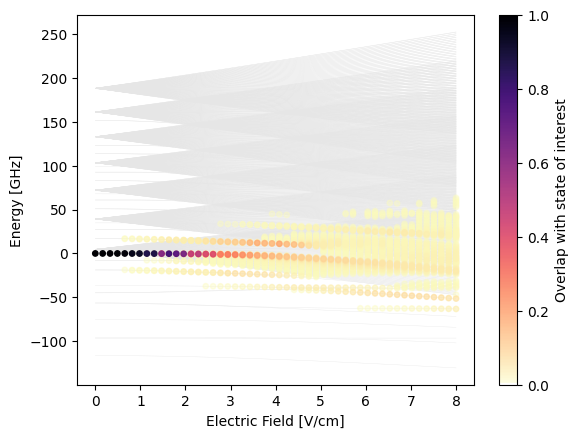

In [4]:
fig, ax = plt.subplots()

ax.set_xlabel("Electric Field [V/cm]")
ax.set_ylabel("Energy [GHz]")

try:
    ax.plot(electric_fields, np.array(eigenenergies), c="0.9", lw=0.25, zorder=-10)
except ValueError:  # inhomogeneous shape -> no simple line plot possible
    for x, es in zip(electric_fields, eigenenergies):
        ax.plot([x] * len(es), es, c="0.9", ls="None", marker=".", zorder=-10)

x_repeated = np.hstack(
    [val * np.ones_like(es) for val, es in zip(electric_fields, eigenenergies)]
)
energies_flattened = np.hstack(eigenenergies)
overlaps_flattened = np.hstack(overlaps)
sorter = np.argsort(overlaps_flattened)

scat = ax.scatter(
    x_repeated[sorter],
    energies_flattened[sorter],
    c=overlaps_flattened[sorter],
    s=15,
    vmin=0,
    vmax=1,
    cmap=alphamagma,
)

fig.colorbar(scat, ax=ax, label="Overlap with state of interest")

plt.show()